# 01 · Introducción a la IA en Audiología

Objetivos:
- Cargar un dataset pequeño de audiogramas simulados
- Visualizar curvas audiométricas con matplotlib

In [3]:
# Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('../data/raw/audiograms.csv')
df.head()

,id,edad,sexo,oido,f250,f500,f1000,f2000,f4000,f8000
0,1,43,F,L,47.5,52.0,44.8,45.8,39.1,44.3
1,1,43,F,R,10.1,13.7,26.6,24.0,30.8,43.1
2,2,27,M,L,20.6,21.9,13.2,19.7,20.4,22.0
3,2,27,M,R,92.2,93.0,96.3,99.6,103.9,102.2
4,3,76,M,L,32.2,33.5,38.5,46.6,62.0,83.0


## Visualización de audiogramas (placeholder)
Completa con tus reglas de simulación o datos anonimizados.

In [7]:
# === Generación de audiogramas realistas (un solo oído por paciente) ===
import numpy as np
import pandas as pd

FREQS = [250, 500, 1000, 2000, 4000, 8000]

PATTERN_P = {
    "normal_flat": 0.30,
    "mild_flat": 0.12,
    "mild_slope_HF": 0.10,
    "moderate_flat": 0.10,
    "moderate_slope_HF": 0.12,
    "severe_slope_HF": 0.08,
    "profound": 0.06,
    "reverse_slope_LF": 0.03,
    "cookie_bite_MF": 0.05,
    "noise_notch_4k": 0.04,
}
PATTERNS = list(PATTERN_P.keys())
P_WEIGHTS = np.array([PATTERN_P[k] for k in PATTERNS], dtype=float)
P_WEIGHTS /= P_WEIGHTS.sum()

def _bounded(arr, lo=0.0, hi=120.0):
    return np.clip(np.asarray(arr, dtype=float), lo, hi)

def _smooth_noise(scale=3.0, n=len(FREQS)):
    steps = np.random.normal(0, scale, size=n)
    walk = np.cumsum(steps)
    return walk - walk.mean()

def _pattern_curve(kind):
    f = np.array(FREQS, dtype=float)
    if kind == "normal_flat":
        rel = np.zeros_like(f) + np.random.uniform(0, 10)
    elif kind == "mild_flat":
        rel = np.full_like(f, np.random.uniform(15, 25))
    elif kind == "mild_slope_HF":
        rel = np.interp(f, [250, 8000], [10, 35])
    elif kind == "moderate_flat":
        rel = np.full_like(f, np.random.uniform(35, 45))
    elif kind == "moderate_slope_HF":
        rel = np.interp(f, [250, 8000], [20, 60])
    elif kind == "severe_slope_HF":
        rel = np.interp(f, [250, 8000], [35, 85])
    elif kind == "profound":
        rel = np.full_like(f, np.random.uniform(90, 105))
    elif kind == "reverse_slope_LF":
        rel = np.interp(f, [250, 8000], [45, 15])
    elif kind == "cookie_bite_MF":
        rel = 15 + 20 * np.exp(-((np.log2(f) - np.log2(1000))**2) / (2 * 0.5**2))
    elif kind == "noise_notch_4k":
        rel = np.full_like(f, 15.0)
        rel[f == 4000] += np.random.uniform(15, 25)
    else:
        rel = np.zeros_like(f)
    curve = rel + _smooth_noise(scale=3.0)
    return _bounded(curve, 0, 120)

def _age_effect(age):
    f = np.array(FREQS, dtype=float)
    w = (np.log2(f) - np.log2(f.min())) / (np.log2(f.max()) - np.log2(f.min()))
    decades = max((age - 20) / 10.0, 0)
    return decades * (1.5 + 2.5 * w)  # ~1.5 dB/dec LF → ~4 dB/dec HF

def synth_audiogram(age, sex, kind=None):
    if kind is None:
        kind = np.random.choice(PATTERNS, p=P_WEIGHTS)
    curve = _pattern_curve(kind)
    curve = curve + _age_effect(age)
    curve = curve + np.random.normal(0, 2.0, size=len(FREQS))
    return _bounded(curve, 0, 120)

def simulate_dataset(n_patients=160, seed=2026):
    rng = np.random.default_rng(seed)
    rows = []
    for pid in range(1, n_patients + 1):
        age = int(np.clip(np.round(rng.normal(55, 15)), 18, 90))
        sex = rng.choice(["F", "M"])
        curve = synth_audiogram(age, sex)
        row = {"id": pid, "edad": age, "sexo": sex}
        for fr, val in zip(FREQS, curve):
            row[f"f{int(fr)}"] = round(float(val), 1)
        rows.append(row)
    return pd.DataFrame(rows)

# Generar y guardar un solo-oreo por paciente (sin columna 'oido')
df_sim = simulate_dataset(n_patients=160, seed=2026)
df_sim.to_csv("../data/raw/audiograms.csv", index=False)
print("Generado ../data/raw/audiograms.csv con", len(df_sim), "pacientes (1 oído por fila).")



Generado ../data/raw/audiograms.csv con 160 pacientes (1 oído por fila).


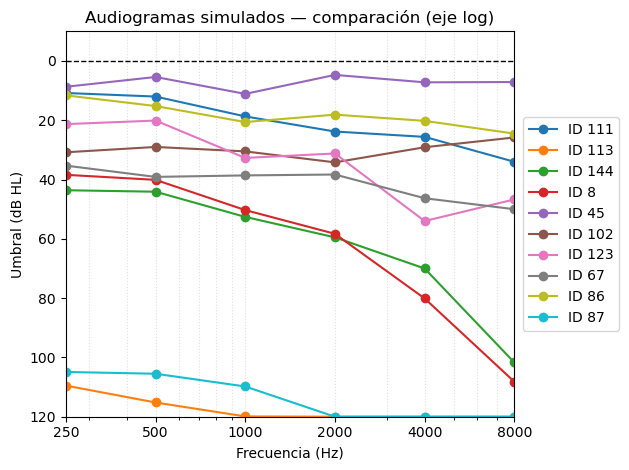

In [30]:

ex_ids = df_sim["id"].sample(10, random_state=0).tolist()
freqs = np.array(FREQS, dtype=float)

plt.figure()
for pid in ex_ids:
    r = df_sim.loc[df_sim["id"] == pid].iloc[0]
    y = [r[f"f{int(f)}"] for f in freqs]
    plt.plot(freqs, y, marker="o", label=f"ID {pid}")

plt.xscale("log")                              # log10 by default
plt.xticks(freqs, [str(int(f)) for f in freqs])
plt.gca().invert_yaxis()                       # HL: mejor arriba
plt.ylim(120, -10)                             # rango fijo en dB HL
plt.xlim(freqs.min(), freqs.max())
plt.axhline(y=0, color='k', linewidth=1, linestyle = "--")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Umbral (dB HL)")
plt.title("Audiogramas simulados — comparación (eje log)")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.grid(True, which="both", axis="x", linestyle=":", alpha=0.4)
plt.show()


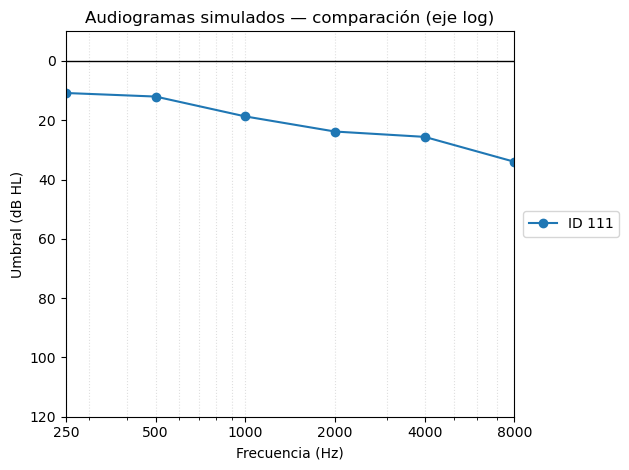

In [29]:
ex_ids = df_sim["id"].sample(1, random_state=0).tolist()
freqs = np.array(FREQS, dtype=float)

plt.figure()
for pid in ex_ids:
    r = df_sim.loc[df_sim["id"] == pid].iloc[0]
    y = [r[f"f{int(f)}"] for f in freqs]
    plt.plot(freqs, y, marker="o", label=f"ID {pid}")

plt.xscale("log")                              # log10 by default
plt.xticks(freqs, [str(int(f)) for f in freqs])
plt.gca().invert_yaxis()                       # HL: mejor arriba
plt.ylim(120, -10)                             # rango fijo en dB HL
plt.xlim(freqs.min(), freqs.max())
plt.axhline(y=0, color='k', linewidth=1, linestyle = "--")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Umbral (dB HL)")
plt.title("Audiogramas simulados — comparación (eje log)")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.grid(True, which="both", axis="x", linestyle=":", alpha=0.4)
plt.show()


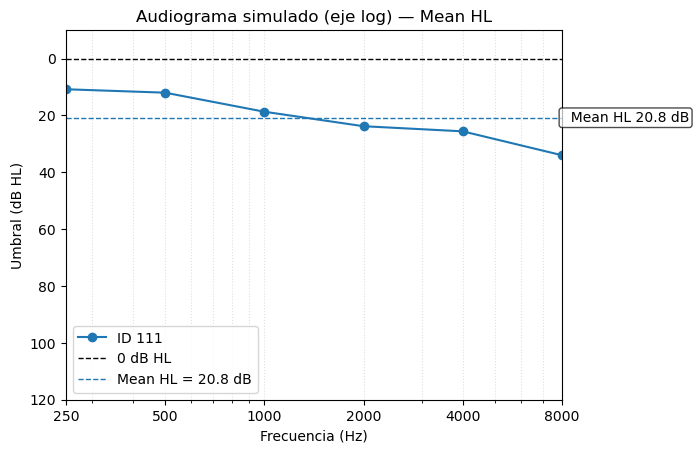

In [33]:
# One-patient plot + Mean HL overlay (no PTA)
ex_ids = df_sim["id"].sample(10, random_state=0).tolist()
freqs = np.array(FREQS, dtype=float)

pid = ex_ids[0]
r = df_sim.loc[df_sim["id"] == pid].iloc[0]
y = np.array([r[f"f{int(f)}"] for f in freqs], dtype=float)

mean_hl = float(y.mean())

plt.figure()
plt.plot(freqs, y, marker="o", label=f"ID {pid}")

plt.xscale("log")
plt.xticks(freqs, [str(int(f)) for f in freqs])
plt.gca().invert_yaxis()
plt.ylim(120, -10)
plt.xlim(freqs.min(), freqs.max())
plt.axhline(y=0, color = "k", linewidth=1, label="0 dB HL", linestyle = "--")

# Mean HL reference
plt.axhline(y=mean_hl, linestyle="--", linewidth=1, label=f"Mean HL = {mean_hl:.1f} dB")
plt.text(freqs.max(), mean_hl, f"  Mean HL {mean_hl:.1f} dB",
         va="center", ha="left",
         bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Umbral (dB HL)")
plt.title("Audiograma simulado (eje log) — Mean HL")
plt.legend()
plt.grid(True, which="both", axis="x", linestyle=":", alpha=0.4)
plt.show()


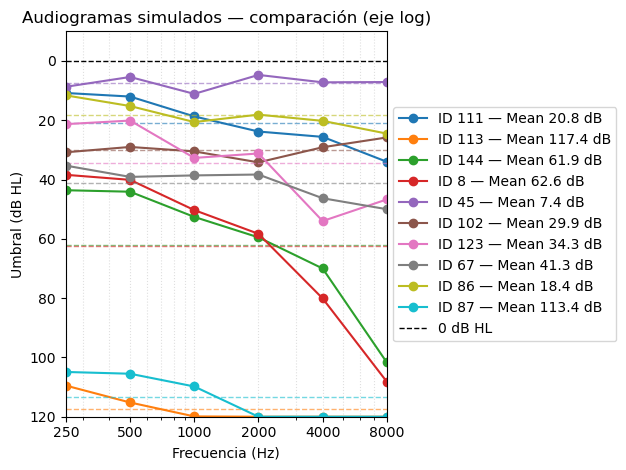

In [35]:
# 10-subject comparison with per-subject dashed mean lines
ex_ids = df_sim["id"].sample(10, random_state=0).tolist()
freqs = np.array(FREQS, dtype=float)

fig, ax = plt.subplots()

means = {}
for pid in ex_ids:
    r = df_sim.loc[df_sim["id"] == pid].iloc[0]
    y = np.array([r[f"f{int(f)}"] for f in freqs], dtype=float)
    mean_hl = float(y.mean())
    means[pid] = mean_hl

    # plot the audiogram
    (line,) = ax.plot(freqs, y, marker="o", label=f"ID {pid} — Mean {mean_hl:.1f} dB")
    # dashed mean line in the same color as the curve
    ax.axhline(mean_hl, linestyle="--", linewidth=1, alpha=0.6,
               color=line.get_color())

    # (optional) small label near the right edge for the mean value:
    # ax.annotate(f"{mean_hl:.1f} dB", xy=(freqs[-1], mean_hl),
    #             xytext=(6, 0), textcoords="offset points",
    #             va="center", ha="left", color=line.get_color())

ax.set_xscale("log")
ax.set_xticks(freqs)
ax.set_xticklabels([str(int(f)) for f in freqs])
ax.invert_yaxis()
ax.set_ylim(120, -10)
ax.set_xlim(freqs.min(), freqs.max())
ax.axhline(y=0, color="k", linewidth=1, linestyle="--", label="0 dB HL")

ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("Umbral (dB HL)")
ax.set_title("Audiogramas simulados — comparación (eje log)")

# legend outside, right side
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
fig.tight_layout()

ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.4)
plt.show()

# (Optional) print means in console
# for pid in sorted(means): print(f"ID {pid}: {means[pid]:.1f} dB")
